In [5]:
from typing import TypedDict, Annotated, Sequence
from fastapi import HTTPException

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.message import add_messages, BaseMessage
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode

# from agent.tools import VectorSearchTool
from langchain_groq import ChatGroq
# from core.config import settings


In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
from core.config import settings
from uuid import uuid4


model_name = settings.EMBEDDING_MODEL
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)


def create_embeddings(docs):
    """Create embeddings of the specified texts"""

    vectors = []
    for doc in docs:
        text = doc.page_content
        metadata = dict(doc.metadata)
        metadata["text"] = text
        doc_id = doc.id or str(uuid4())      # Generate random id if id in docs is null

        embedding = hf.embed_query(text)

        vectors.append({
            "id": doc_id,
            "values": embedding,
            "metadata": metadata,
            }
        )
    
    return vectors







/home/deadgrunz/PalmMind/backend-system-task-fastapi/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from langchain.tools import BaseTool
from pinecone import Pinecone
from core.config import settings
# from embedding.embedder import hf
from pydantic import Field, PrivateAttr


class VectorSearchTool(BaseTool):
    """Tool for searching a vector db to retrieve semantically similar chunks"""
    name: str = "DocumentSearch"
    description: str =  (
        "Search for relevant documents and information based on a query. "
        "Use this tool when you need to find specific information or context "
        "to answer questions. Input should be a clear search query or question."
    )
    # query: str = Field()
    method: str = Field(default="cosine", description="The algorithm for semantic similarity search.")

    _client: Pinecone = PrivateAttr()

    def __init__(self, method: str = "cosine"):
        super().__init__()
        try:
            pc = Pinecone(api_key=settings.PINECONE_API_KEY)
            self._client = pc.Index("file-embeddings-dense")
            self.method = method
        except Exception as e:
            print(f"Error initializing Pinecone client: {e}")
            raise

    def _run(self, query: str) -> str:
        """Execute the vector search"""
        print(f"[TOOL CALL] VectorSearchTool was invoked with query: {query}")
        query_embed = hf.embed_query(query)

        results = self._client.query(
            # namespace=settings.PINECONE_NAMESPACE
            vector=query_embed,
            top_k=3,
            include_metadata=True,
            metric=self.method,
            include_values=False
        )

        matches = getattr(results, "matches", []) 
        if not matches:
            return "No matching content found."

        chunks = [m.metadata.get("text", "") for m in matches if "text" in m.metadata]
        if not chunks:
            return "No text metadata found in the results."

        print(f"Retrieving {len(chunks)} document chunks")
        return "\n\n".join(chunks)
    

    # async def _arun(self, query: str) -> str:
    #     """Async version of the tool"""
    #     return self._run(query)






In [9]:
# State schema
class AgentState(TypedDict):
    query: str
    context: str
    messages: Annotated[Sequence[BaseMessage], add_messages]



retriever_tool = VectorSearchTool()
tools = [retriever_tool]
llm = ChatGroq(
                temperature=0.7,
                groq_api_key=settings.GROQ_API_KEY,
                model_name=settings.LLM_MODEL,
            ).bind_tools(tools=tools)



In [ ]:
# NODES
def retrieve(state: AgentState) -> AgentState:
    print("[GRAPH NODE] Retrieval Invoked")
    context = retriever_tool._run(state["query"])
    return {"context": context}


def agent(state: AgentState) -> AgentState:
    """Agent node that decides which tool to call"""
    print("[GRAPH NODE] LLM generation Invoked")

    context = state["context"]
    query = state["query"]
    system_message = SystemMessage(
        content="You are a helpful assistant that answers questions based on retrieved documents.\n"
                "Always use the DocumentSearch tool to find relevant information before answering questions.\n"
                "Base your answers on the retrieved content and cite the sources when possible.\n"
                "Important Note: Answer with maximum one tool call.\n"
                "Use the following context to answer the question:\n\n"
                "Context:\n"
                f"{context}\n"
                "Question:\n"
                f"{query}"
    )

    human_message = HumanMessage(content=query)
    try:
        response = llm.invoke({"messages": [system_message, human_message]})
        # print(response)
        # return response["messages"][-1].content
        return {"messages": [response]}

    except Exception as e:
        print(f"Error in ask_agent: {e}")
        raise HTTPException(status_code=503, detail="LLM service temporarily unavailable. Please try again.")
    

def should_continue(state: AgentState) -> AgentState:
    """Decide whether the agent should continue tool calling"""

    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return "exit"


In [14]:
graph = StateGraph(AgentState)

graph.add_node("agent", agent)

retriever_tool_node = ToolNode([retriever_tool])
graph.add_node("retriever", retrieve)

# graph.add_edge(START, agent)
graph.add_conditional_edges("agent",
                            should_continue,
                            {
                                "tools": "retriever",
                                "exit": END
                            })
graph.add_edge("retriever", "agent")

graph.set_entry_point("agent")
# graph.set_finish_point("agent")

rag_app = graph.compile()

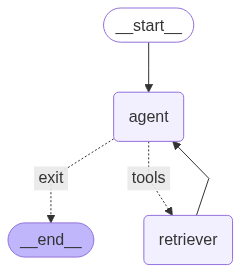

In [15]:
from IPython.display import display, Image
display(Image(rag_app.get_graph().draw_mermaid_png()))